# 0. Introduction
We have the following tables:

\
named `games_data`
| profile_code (int) | hours_on_record (int) | game_code (int) |
|---|---|---|
| 455798 | 47 | 66984 |

\
named `game_codes`
| game_code (int) | game_name (str) |
|---|---|
| 38584 | Path of Exile |

\
named `nonzero_players`
| profile_code (int) | total_hours (int) |
|---|---|
| 346891 | 2550 |  


A dictionary `client_games = {game_code : hours_on_record}` \
will be a representation of our knowledge about the client.

Let `n` - number of players, `L` - list of gamecodes \
( Should `L` contain game_codes in `client_games` ? )

Find `n` representatives (`profile_code`s) which are close in total sum of 'hours_on_record'\
then order them by distance distribution of game_hours in games from the list `L`.

With sql query build a table named `close_total` with profiles which have close sum of 'hours_on_record', then order `close_total`
by the distance between distributions of games in the table and `client_games`.

Comments:
1. For experiments we can use some of the existing rows and check predicted against true `hours_on_record`.
2. ...

## 0.1. DB connection & Client

In [1]:
from sqlalchemy import create_engine
import polars as pl
from polars.dataframe.frame import DataFrame
import numpy as np
import re

from steam_players_orm.db_model import GamesData, GameCodes

server = 'localhost'
database = 'steam_players'
driver = 'ODBC Driver 17 for SQL Server'
# username = '<your_username>'
# password = '<your_password>'

engine = create_engine(f'mssql://{server}:1433/{database}?trusted_connection=yes&driver={driver}')

## 0.2. Queries playground
sqlalchemy orm classes: `GamesData`, `GameCodes`, `NonzeroPlayers`.

In [2]:
from sqlalchemy import select
from steam_players_orm.db_model import GamesData, GameCodes, NonzeroPlayers

#### Check the name of game with code
game_code = 38584 #708 #8025
query_name_with_code = (
    select(GameCodes.game_code, GameCodes.game_name)
    .filter(GameCodes.game_code == game_code)
)
df_name_with_code = pl.read_database(
    query=query_name_with_code, connection=engine)
print(df_name_with_code)

# #### Find the code of game named
# game_name = "Path of Exile" #"Borderlands 2"
# query_code_with_name = (
#     select(GameCodes.game_code, GameCodes.game_name)
#     .filter(GameCodes.game_name == game_name)
# )
# df_code_with_name = pl.read_database(
#     query=query_code_with_name, connection=engine)
# print(df_code_with_name)

# #### SELECT TOP 
# num_top = 10
# query_top_players_in_game = (
#     select(GamesData.hours_on_record, GamesData.profile_code)
#     .filter(GamesData.game_code == game_code)
#     .order_by(GamesData.hours_on_record.desc())
#     .limit(num_top)
# )

# df_top_players_in_game = pl.read_database(
#     query=query_top_players_in_game, connection=engine
# )
# print(df_top_players_in_game)

shape: (1, 2)
┌───────────┬───────────────┐
│ game_code ┆ game_name     │
│ ---       ┆ ---           │
│ i64       ┆ str           │
╞═══════════╪═══════════════╡
│ 38584     ┆ Path of Exile │
└───────────┴───────────────┘


In [3]:
from steam_players_orm.db_model import GamesData, GameCodes
from sqlalchemy import func, select, case
# from sqlalchemy.dialects import mssql

profile = [346891, 221595, 281937]
num_top = 10
query_top_games_of_player = (
    select(GamesData.profile_code, GamesData.hours_on_record, GamesData.game_code)
    .filter(GamesData.profile_code.in_(profile))
    .order_by(GamesData.profile_code, GamesData.hours_on_record.desc())
    # .limit(num_top)
)

df_top_games_of_player = pl.read_database(
    query=query_top_games_of_player, connection=engine
)
print(df_top_games_of_player)

shape: (671, 3)
┌──────────────┬─────────────────┬───────────┐
│ profile_code ┆ hours_on_record ┆ game_code │
│ ---          ┆ ---             ┆ ---       │
│ i64          ┆ i64             ┆ i64       │
╞══════════════╪═════════════════╪═══════════╡
│ 221595       ┆ 1612            ┆ 8025      │
│ 221595       ┆ 1274            ┆ 54197     │
│ 221595       ┆ 943             ┆ 40000     │
│ 221595       ┆ 907             ┆ 34770     │
│ 221595       ┆ 820             ┆ 34714     │
│ …            ┆ …               ┆ …         │
│ 346891       ┆ 0               ┆ 27813     │
│ 346891       ┆ 0               ┆ 64370     │
│ 346891       ┆ 0               ┆ 11080     │
│ 346891       ┆ 0               ┆ 56420     │
│ 346891       ┆ 0               ┆ 22066     │
└──────────────┴─────────────────┴───────────┘


# 1. Whom we recommend to
Here we create `history_dict` that contain (game_code : hours_on_record) pairs.
1. Select a `profile_code` and some game codes below the most played.
2. create by provding `{ game_code : hours_on_record , ...}`

Then sort profile_codes from the closes to provided history.

In [4]:
# # 1. SELECT
# player_list = [346891, 348574, 353454]
# # 2. player dict 
# player_dict = {}

from steam_players_orm.db_queries import player_history, distribution_distance_query
from steam_players_orm.polars_funcs import df_to_id_val_dict

client_code = 2584514

df_client_record = pl.read_database(
    query=player_history(client_code),
    connection=engine.connect()
    )

history_dict = df_to_id_val_dict(df_client_record, top=10)
print("\n".join(f"{key:>7}{':':>2}{val :>5}" for key, val in history_dict.items()))


   8025 : 1789
  52848 :  832
  54197 :  218
  18723 :  192
  26433 :  179
  57411 :  130
  49320 :  117
  46320 :  115
    708 :  103
   8449 :   91


In [5]:
# from pr_main import SteamUser
# user = SteamUser(2584514)

## 1.1. Players close to `history_dict`
<a id="close_players"></a>

In [6]:
df_profiles_close_to_history_dict = pl.read_database(
    query=distribution_distance_query(history_dict), 
    connection=engine.connect()
    )
df_profiles_close_to_history_dict.head()

profile_code,distr_dist
i64,f64
208469,0.221986
163495,0.242378
404942,0.245353
307550,0.24615
244444,0.24615


# 2. Data matrix preparation
In this section assume that we have a \
`history_dict = {game_0 : hours_0, game_1 : hours_1, ...}`.\
and\
`DataFrame` with `profile_code`s close (or not) to `history_dict`\

Below we follow the following steps:
1. Add some other `game_code`s to existing keys from `history_dict`.\
(for example we can add overall most popular) 
2. Find hour percentiles for `game_code`s
3. create a history table for players found in [Players close to `history_dict`](#close_players) in chosen games.
4. map `hour_on_record` values to ranks acording to percentiles from step 2.

In [7]:
# arguments:
# history_dict = user.history_dict

df_top_of_2584514 = df_client_record.top_k(10, by='hours_on_record')
game_codes = df_top_of_2584514['game_code'].to_list()
game_hour = df_top_of_2584514['hours_on_record'].to_list()
input_dict = {code : hours for code, hours in df_client_record[['game_code', 'hours_on_record']].iter_rows()}
input_dict

{8025: 1789,
 52848: 832,
 54197: 218,
 18723: 192,
 26433: 179,
 57411: 130,
 49320: 117,
 46320: 115,
 708: 103,
 8449: 91}

## 2.1. More `game_code`s
Join games with most total hours and owned by most players
Find
1. `n_total_hours` games with most total gameplay
2. `n_total_owned` games owned by most players

In [8]:
from steam_players_orm.db_queries import top_n_accum
from sqlalchemy import func
from steam_players_orm.db_model import GamesData

n_total_hours = 50
n_total_owned = 50

df_top_played = pl.read_database(
    query=top_n_accum(n_total_hours), connection=engine
)

query_top_owned = top_n_accum(
    n_total_owned,
    column=GamesData.game_code,
    col_label="game_code",
    accum_func=func.count,
    accum_col=GamesData.profile_code,
    accum_label="num_of_players")

df_top_owned = pl.read_database(
    query=query_top_owned, connection=engine
)

popular_games = set(df_top_owned['game_code'].to_list()).union(set(df_top_played['game_code'].to_list()))
game_codes = list(set(history_dict.keys()).union(popular_games))
print(f"There are {len(game_codes)-len(history_dict.keys())} more popular games not included in history_dict")

There are 61 more popular games not included in history_dict


In [22]:
game_codes

[8449,
 46084,
 50438,
 51462,
 67080,
 26126,
 25872,
 60690,
 28437,
 11287,
 50718,
 18723,
 61475,
 805,
 27685,
 61481,
 8745,
 27181,
 63283,
 66109,
 24895,
 40000,
 26433,
 57411,
 68164,
 49221,
 1351,
 11080,
 1873,
 9557,
 8025,
 4186,
 40799,
 49765,
 45165,
 53870,
 52848,
 64370,
 14706,
 45953,
 41091,
 27016,
 45705,
 1160,
 48524,
 56204,
 56205,
 56207,
 42659,
 49320,
 56489,
 33966,
 48559,
 48560,
 176,
 48820,
 54197,
 18616,
 38584,
 26811,
 35520,
 28355,
 708,
 40131,
 43203,
 62157,
 34770,
 32726,
 67822,
 46320,
 30712]

## 2.2. Percentiles of hours of gameplay 
Find percentiles of gameplay hours for each game.

In [23]:
from steam_players_orm.db_queries import hour_percentiles_for_games

percentiles = [ 0.2, 0.4, 0.6, 0.8]

df_hour_percentiles = pl.read_database(
    query = hour_percentiles_for_games(game_codes, q_list=percentiles),
    connection=engine
) 
print(df_hour_percentiles.head())

shape: (5, 5)
┌───────────┬──────┬──────┬──────┬───────┐
│ game_code ┆ q_20 ┆ q_40 ┆ q_60 ┆ q_80  │
│ ---       ┆ ---  ┆ ---  ┆ ---  ┆ ---   │
│ i64       ┆ f64  ┆ f64  ┆ f64  ┆ f64   │
╞═══════════╪══════╪══════╪══════╪═══════╡
│ 38584     ┆ 0.0  ┆ 0.0  ┆ 2.0  ┆ 17.0  │
│ 42659     ┆ 0.0  ┆ 0.0  ┆ 1.0  ┆ 6.0   │
│ 54197     ┆ 3.0  ┆ 20.0 ┆ 68.0 ┆ 242.0 │
│ 67822     ┆ 0.0  ┆ 5.0  ┆ 27.0 ┆ 100.0 │
│ 46320     ┆ 1.0  ┆ 14.0 ┆ 45.0 ┆ 120.0 │
└───────────┴──────┴──────┴──────┴───────┘


## 2.3. Players history table

For two lists\
    `profiles = [123, 456, 789, ...]`\
    `games___ = [111, 222, 333, ...]`\
create a table :

| profile_code | game_111 | game_222 | game_333 | ... |
|---|---|---|---|---|
| 123 |  |  |  |  |
| 456 |  |  |  |  |
| 789 |  |  |  |  |
| ... |  |  |  |  |

where for example the place (456, game_222) contains `hours_on_record` of player 456 in game 222.

In [59]:
from steam_players_orm.db_queries import players_history_in_games#, player_history

# client_code = 2584514

# df_client_record = pl.read_database(
#     query=player_history(client_code), 
#     connection=engine.connect()
#     )


profile_codes = df_profiles_close_to_history_dict.top_k(k=200, by='distr_dist')['profile_code'].to_list()
profile_codes = [i for i in profile_codes if i != client_code]

players_history = pl.read_database(
    query=players_history_in_games(
        game_codes=game_codes,
        profile_codes=profile_codes,
    ),
    connection=engine,
)
players_history.head()

profile_code,8449,46084,50438,51462,67080,26126,25872,60690,28437,11287,50718,18723,61475,805,27685,61481,8745,27181,63283,66109,24895,40000,26433,57411,68164,49221,1351,11080,1873,9557,8025,4186,40799,49765,45165,53870,52848,64370,14706,45953,41091,27016,45705,1160,48524,56204,56205,56207,42659,49320,56489,33966,48559,48560,176,48820,54197,18616,38584,26811,35520,28355,708,40131,43203,62157,34770,32726,67822,46320,30712
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
281903,1,0,3561,0,112,0,15,7,0,47,0,136,0,0,4,2,0,1368,0,71,0,297,440,240,27,0,5,0,0,0,143,1,276,1,0,0,27,0,0,1,43,0,1,16,0,0,0,23,0,0,15,0,130,0,0,0,68,41,0,0,0,2,95,23,19,3,0,20432,0,0,83
397412,1,0,327,0,0,0,0,0,0,16,8,5,0,0,9,1,296,25,0,0,0,13,0,33,0,607,162,0,3,0,240,123,0,0,0,16,3,0,0,0,0,0,0,0,0,0,0,81,0,0,1,0,1,0,0,0,0,22,0,0,0,0,69,19,136,10,10,0,30,534,50
196854,0,0,2477,0,0,0,0,7,0,0,76,4,825,0,0,19,41,0,0,0,0,410,68,39,34,2,0,4,0,29,98,53,1,12,0,108,0,0,0,0,0,0,0,0,0,0,0,24,1,0,0,18,0,0,0,0,7,25,0,0,0,2,3,75,0,0,4068,0,0,0,3
58819,15,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1532,0,0,0,0,5,0,0,0,152,9,0,0,7,166,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,27,0,16,0,0,0,0,10,3
246873,0,0,47,0,0,0,0,0,0,0,563,0,0,0,0,0,0,17,0,0,0,375,17,2,0,0,0,0,364,0,0,0,0,5,0,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,4,78,0,0,0,0,16,0,0,5,0,0,0,1651,0


## 2.4. Mapping history to raitings
Based on percentiles in selected games we map history to raitings.

In [11]:
from steam_players_orm.polars_funcs import map_history_to_ranks_from_percentiles

df_data = map_history_to_ranks_from_percentiles(players_history, df_hour_percentiles)
df_data.head()

profile_code,8449,46084,50438,51462,67080,26126,25872,60690,28437,11287,50718,18723,61475,805,27685,61481,8745,27181,63283,66109,24895,40000,26433,57411,68164,49221,1351,11080,1873,9557,8025,4186,40799,49765,45165,53870,52848,64370,14706,45953,41091,27016,45705,1160,48524,56204,56205,56207,42659,49320,56489,33966,48559,48560,176,48820,54197,18616,38584,26811,35520,28355,708,40131,43203,62157,34770,32726,67822,46320,30712
i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
414893,2,4,3,1,0,0,2,1,1,4,0,1,3,1,4,2,1,3,1,0,4,4,1,4,1,4,2,3,1,2,0,2,2,3,0,3,0,4,1,2,2,4,1,2,1,2,4,1,2,0,4,2,2,4,3,3,4,4,2,4,4,2,3,1,3,0,1,2,4,1,3
388764,0,4,1,1,0,0,2,0,1,2,0,1,2,1,1,1,0,2,3,0,4,0,0,3,1,1,0,1,1,2,0,2,2,2,0,2,0,4,1,2,2,4,3,2,1,2,4,4,2,0,2,2,2,4,3,3,2,2,2,4,4,1,2,0,1,0,1,0,3,1,2
171570,0,4,3,1,0,3,2,3,1,2,2,0,4,1,1,4,3,4,0,0,4,2,4,0,2,4,0,2,4,2,0,4,4,1,0,3,2,4,1,2,2,4,1,2,2,2,4,2,2,3,2,2,2,4,3,4,0,4,2,4,4,4,1,0,0,0,3,0,1,4,1
65244,1,4,4,2,0,0,4,0,1,4,0,0,4,1,1,4,0,3,1,2,4,4,2,3,4,1,3,2,1,3,1,4,3,1,0,3,2,4,3,2,2,4,2,2,1,2,4,2,2,0,4,2,3,4,3,3,2,3,2,4,4,2,3,3,4,0,3,0,3,3,4
375746,0,4,4,1,0,3,2,0,1,1,0,1,2,1,3,4,0,4,0,4,4,0,1,1,4,1,0,1,1,2,0,1,4,1,3,0,2,4,1,2,2,4,1,2,1,2,4,1,2,0,4,2,3,4,3,3,0,2,2,4,4,1,1,2,0,1,4,0,1,0,1


## 2.5. `game_code`s & `game_name`s relations

In [58]:
# order of games in game_codes is the same as columns in df_data
game_codes == list(map(int,df_data.select(pl.exclude('profile_code')).columns))

def game_names_from_game_codes(game_codes, engine):
    """ Selection of game_code, game_name keeping the order of game_codes
        used later for labeling """
    id_ordering = case(
        {_id: index for index, _id in enumerate(game_codes)},
        value=GameCodes.game_code
    )
    query_name_with_code = (
        select(GameCodes.game_code, GameCodes.game_name)
        .filter(GameCodes.game_code.in_(game_codes))
        .order_by(id_ordering)
    )
    df_name_with_code = pl.read_database(
        query=query_name_with_code, connection=engine)
    return df_name_with_code

# game_names_from_game_codes(game_codes, engine=engine)
# game_names_from_game_codes(
#     game_codes=[game_code for game_code in game_codes if game_code not in history_dict.keys()],
#     engine=engine)

# 3. CSMC for single user
With players histories mapped to ranks we shall attempt to predict \
ranks of games in `game_codes` based on `history_dict`.

## 3.1. sanity check
check if `client_code` is not present in our data

In [12]:
len(df_data.filter(pl.col("profile_code") == client_code))

0

## 3.2. rank check and singular values

In [13]:
col_users = df_data.select(pl.exclude('profile_code')).to_numpy().astype(float).T
print(f"Size of M is {col_users.shape},\n\
rank(M) = {np.linalg.matrix_rank(col_users)}")

Size of M is (71, 200),
rank(M) = 64


the norm of data matrix = 285.91


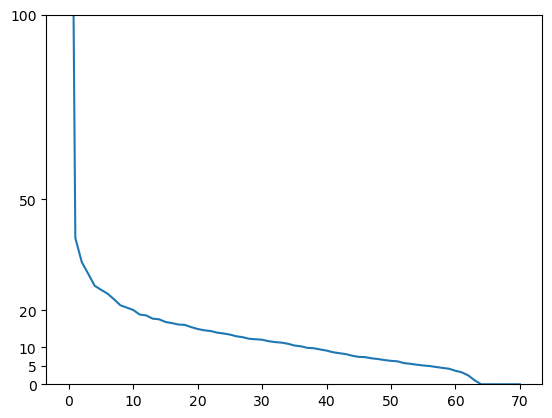

In [14]:
import matplotlib.pyplot as plt

ys = np.linalg.svd(col_users, full_matrices=False, compute_uv=False)
xs = [x for x in range(len(ys))]

print(f"the norm of data matrix = {np.linalg.norm(col_users):.2f}")
fig, ax = plt.subplots()
ax.plot(xs, ys)
ax.set_ylim(0,100)
plt.yticks([0, 5, 10, 20, 50, 100])
plt.show()

## 3.3. Preparing `M_incomplete`
0. Get the full data about client for comparison 
1. Hide some entries since we know only `history_dict`
2. Joing data and client column

In [15]:
# 0. Get the full data about client for comparison 
df_client_in_game_codes = pl.read_database(
    query=players_history_in_games(
        game_codes=game_codes,
        profile_codes=[client_code],
    ),
    connection=engine,
)
df_full_client_ranks = map_history_to_ranks_from_percentiles(df_client_in_game_codes, df_hour_percentiles)
Full_client_in_game_codes = df_full_client_ranks.select(pl.exclude("profile_code")).to_numpy().astype(float).reshape(-1)
Full_client_in_game_codes

array([3., 4., 2., 1., 0., 0., 2., 0., 1., 1., 0., 3., 2., 1., 4., 1., 0.,
       0., 0., 0., 4., 3., 4., 2., 2., 3., 0., 4., 1., 2., 3., 4., 2., 1.,
       0., 0., 4., 4., 1., 2., 2., 4., 3., 2., 3., 2., 4., 1., 2., 3., 2.,
       2., 3., 4., 3., 3., 3., 3., 2., 4., 4., 2., 4., 0., 0., 3., 0., 0.,
       1., 3., 2.])

In [16]:
# 1. Hide ranks that are not in `history_dict`
rank_dict = {
    game_code : rank if (game_code in history_dict) else np.nan
    for game_code, rank in zip(game_codes, Full_client_in_game_codes)
}
client_column = np.array(list(rank_dict.values())).reshape(-1,1)
places = np.where(np.isnan(client_column))[0]

In [17]:
# 2. Joing data and client column
import numpy as np
rng = np.random.default_rng(seed=12345)

# col_users
M_incomplete = np.copy(col_users)
num_missing_elements = int(0.0 * col_users.size)
indices_to_zero = rng.choice(range(col_users.size), size=num_missing_elements)
rows, cols = np.unravel_index(indices_to_zero, col_users.shape)
M_incomplete[rows, cols] = np.nan
M_incomplete = np.hstack([M_incomplete, client_column])

## 3.4 CSMC

In [18]:
from csmc import CSMC
solver = CSMC(M_incomplete, col_number=100)
M_filled = solver.fit_transform(M_incomplete)

## 3.5. Scailing
Use linear scaling that maps 0->0 and max(predicted_values) -> 4

In [19]:
predicted_ranks = np.clip(M_filled[:,-1][places],a_min=0,a_max=np.inf)/np.max(M_filled[:,-1][places])*4
true______ranks = Full_client_in_game_codes[places].astype(int)

print(f"{predicted_ranks} <- predicted")
print(f"{true______ranks} <- true values")

[4.         2.87027187 2.48425236 0.         0.62656373 3.10817721
 0.8190636  1.7939623  2.39668837 1.30603703 2.8458829  1.41941737
 1.88631127 3.02451577 1.23411115 1.58314041 0.45278799 1.48771289
 4.         2.50577859 1.81714483 1.60412111 1.82482365 1.98778583
 1.84181248 3.02117118 3.05433004 2.6711272  1.96422709 1.27022188
 2.34819102 4.         1.37636434 2.55681274 2.70804391 4.
 2.78498997 2.41831491 1.66263868 2.4041772  4.         2.41585295
 2.70436679 3.2902103  2.43803462 3.06225444 4.         3.00305281
 3.3285309  2.41633842 3.01933084 4.         4.         1.66294655
 1.87019672 1.6228977  2.36095272 2.90266785 0.68225105 2.3375328
 3.01158853] <- predicted
[4 2 1 0 0 2 0 1 1 0 2 1 4 1 0 0 0 0 4 3 2 3 0 4 1 2 4 2 1 0 0 4 1 2 2 4 3
 2 3 2 4 1 2 2 2 3 4 3 3 3 2 4 4 2 0 0 3 0 0 1 2] <- true values


## 3.5. Graph the comparison 

In [20]:
# game_names from game_codes

predicted_games = []
for game_code in game_codes:
    if game_code not in history_dict.keys():
        predicted_games.append(game_code)


id_ordering = case(
    {_id: index for index, _id in enumerate(predicted_games)},
    value=GameCodes.game_code
)

query_name_with_code = (
    select(GameCodes.game_code, GameCodes.game_name)
    .filter(GameCodes.game_code.in_(predicted_games))
    .order_by(id_ordering)
)
df_name_with_code = pl.read_database(
    query=query_name_with_code, connection=engine)
game_names = df_name_with_code['game_name'].to_list()
# predicted_games

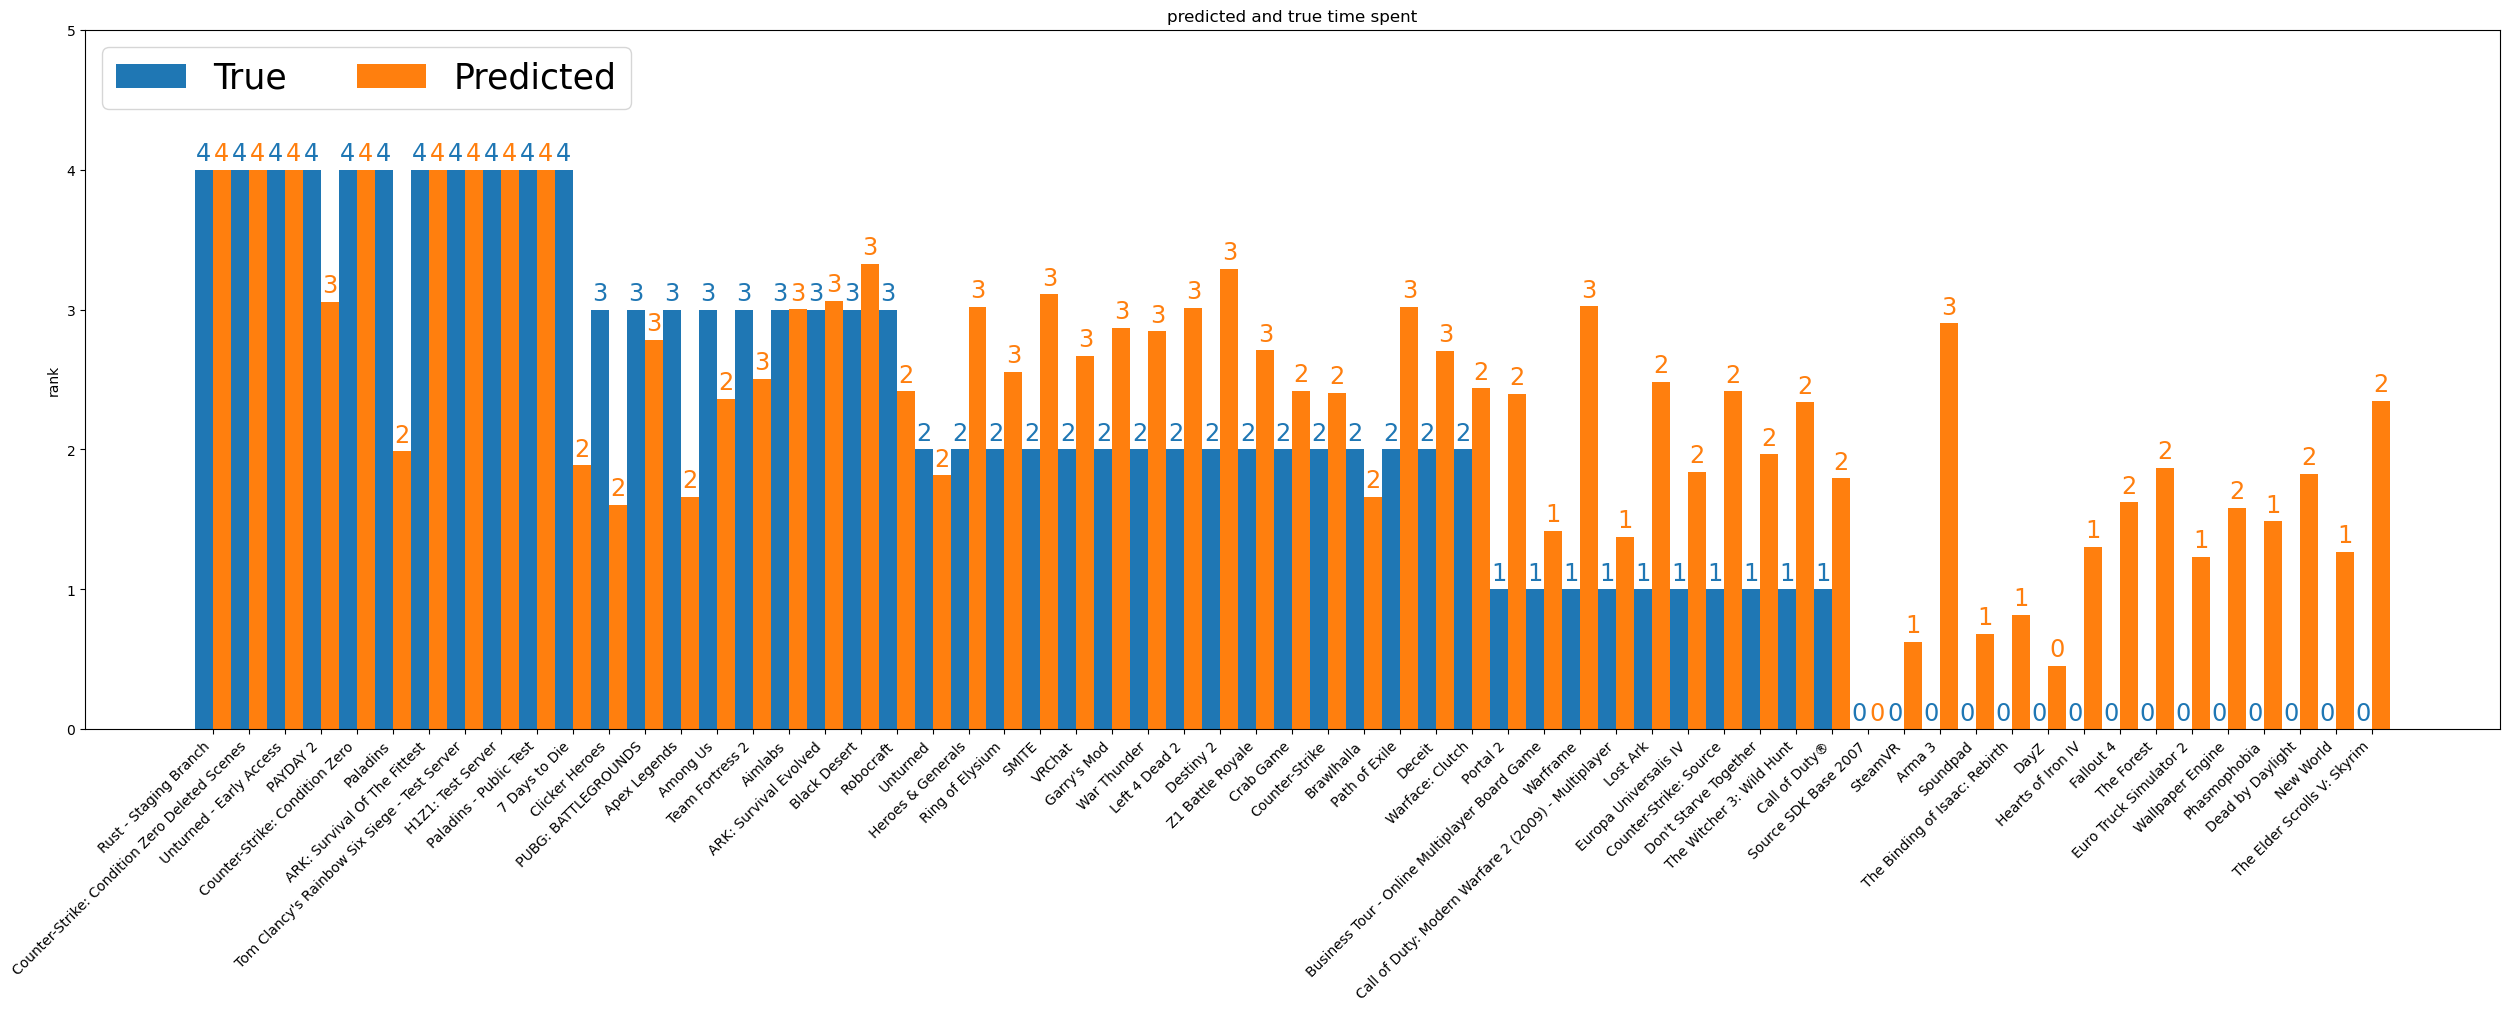

In [21]:
import matplotlib.pyplot as plt

order = np.argsort(true______ranks)[::-1]
true______ranks = true______ranks[order]
predicted_ranks = predicted_ranks[order]

name_list = [game_names[i] for i in order]
hours_to_plot = {
    "True" : true______ranks,
    "Predicted" : predicted_ranks
}

x = np.arange(len(name_list))  # the label locations
width = 0.5  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(figsize=(25,10), layout='constrained')
# fig.figure(figsize=(40, 20))
# ax.set_box_aspect(0.25)

for attribute, measurement in hours_to_plot.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3) fmt
    ax.bar_label(rects, padding=3, fmt= lambda x: f"{x:.0f}",
                color='tab:blue' if attribute == "True" else 'tab:orange',
                size='xx-large')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('rank')
ax.set_title('predicted and true time spent')
ax.set_xticks(x + width, name_list)
ax.set_xticklabels(name_list, rotation = 45, ha="right")
ax.legend(loc='upper left', ncols=2, prop={'size': 25})# fontsize='xx-large'
ax.set_ylim(0, 5)

plt.show()

In [ ]:
nan_idxs = np.where(np.isnan(client_data.reshape(-1)))[0]
kno_idxs = np.delete(np.array(range(len(client_data))), nan_idxs)

np.array(game_codes)[nan_idxs]
predicted = M_filled[:,-1]
propositions = predicted[nan_idxs]
propositions
# game_codes.take([0,1,3])
# print(M_filled[:, -1])
# true_client = players_sample.filter(pl.col("profile_code") == client_code).to_numpy().reshape(-1)[1:]
# print(true_client)
# game_codes
client_complete_dict_lists = dict(
    df_client_record
        .filter(pl.col("game_code")
        .is_in(game_codes))
        .select("game_code","hours_on_record")
        .rows_by_key(key=["game_code"])
        )
client_complete_dict = {key : val[0] for key, val in client_complete_dict_lists.items()}
client_history = np.array([client_complete_dict[key] if key in client_complete_dict else 0 for key in game_codes])

In [187]:
true______hours = client_history[nan_idxs]
predicted_hours = predicted[nan_idxs]
game_codes_in_question = [game_codes[i] for i in nan_idxs]

In [186]:
# SQL retrive game names from codes
def query_game_names_with_(game_codes:list):
    """
    For game_codes = [40000, 8449, 68164] create query:

        SELECT  [game_name]
                ,[game_code]
        FROM [steam_players].[dbo].[game_codes]
        WHERE [game_code] IN (40000, 8449, 68164)
        ORDER BY CASE [game_code]
            WHEN 40000 THEN 1
            WHEN 8449 THEN 2
            WHEN 68164 THEN 3
            ELSE 4
        END;
    """
    first = "SELECT  [game_name], [game_code] \nFROM [steam_players].[dbo].[game_codes]\n"
    where_line = f"WHERE [game_code] IN {*game_codes,}\n"
    order_line = "ORDER BY CASE [game_code]\n"
    whens_list = "\n".join([f"WHEN {game_code} THEN {i + 1}" for i,game_code in enumerate(game_codes)]) + "\n"
    end___line = f"ELSE {len(game_codes) + 1}\nEND;"
    query = (first + 
             where_line +
             order_line +
             whens_list +
             end___line)
    return query

df_game_names_codes = pl.read_database(
    query=query_game_names_with_(game_codes_in_question), 
    connection=engine.connect()
    )

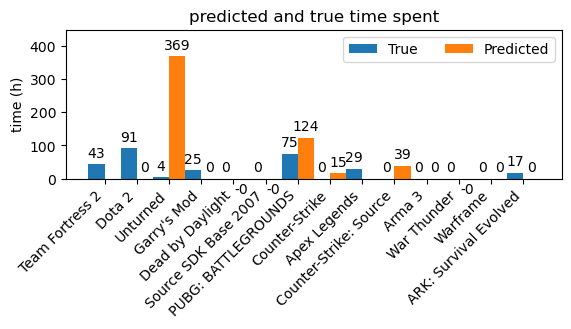

In [211]:
import matplotlib.pyplot as plt

name_list = df_game_names_codes["game_name"].to_list()
hours_to_plot = {
    "True" : true______hours,
    "Predicted" : predicted_hours
}

x = np.arange(len(name_list))  # the label locations
width = 0.5  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots()#layout='constrained')
ax.set_box_aspect(0.3)

for attribute, measurement in hours_to_plot.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3) fmt
    ax.bar_label(rects, padding=3, fmt= lambda x: f"{x:.0f}")
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time (h)')
ax.set_title('predicted and true time spent')
ax.set_xticks(x + width, name_list)
ax.set_xticklabels(name_list, rotation = 45, ha="right")
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 450)

plt.show()

# 4. Users sample

## 4.0. `SteamUser` class

In [1]:
from pr_main import SteamUser, CloseUsers
user = SteamUser(2584514)
close_users = CloseUsers(user=user)

close_users.generate_ranks(num_of_results=10)

In [7]:
import polars as pl
close_users.df_ranks.select(pl.col('profile_code')).to_series().to_list()

[163495,
 168905,
 201414,
 208469,
 210806,
 244444,
 307550,
 388857,
 404942,
 552637]

In [3]:
type(user.df_user_ids_close_to_user)


polars.dataframe.frame.DataFrame

In [11]:
user_12345.find_close_users(num_of_results=50)

In [12]:
user_12345.df_user_ids_close_to_user

profile_code,distr_dist
i64,f64
12345,0.117427
274074,0.330918
44412,0.345709
282874,0.347348
428872,0.347697
…,…
414907,0.446145
382204,0.448905
180305,0.448905


## 4.x. Error agregation